<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Multi_Cell_Model_for_CO2_core_flooding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチセルモデルによるCO2圧入に伴う油層流体の変化

**加藤 (1982)** では、マルチセルモデルを使ったCO2圧入にともなう油層流体の変化、ミシビリティ形成過程についての研究成果が報告されている。CO2 EORのメカニズムを理解するにあたり、非常に面白い話題であり、実際してみることにする。

参考
- 加藤, 1982, CO2の圧入に伴う油層流体変化


ここでのマルチセルモデルの計算フローは以下のとおりとした。

1.   適当なセル数を設定する。これらは１次元方向に連結している。今回はセル数を100とした
2.   各セルに初期の油を設定する
3.   セル１に、セル容積の50%のCO2を圧入する
4.   セル内でフラッシュ計算を行い、各相の組成、K値、密度、体積等を計算する
5.   セル体積からの余剰分がフラクショナルフローにしたがって隣のセルへ流れ込む
6.   セル２から最終セルまで、4.~5.のステップを繰り返す
7.   3.~6.を目的のステップ数繰り返す。今回は、CO2の総圧入量を1.2PVとした


## クラス・関数の作成

**ライブラリのインポート**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

フラッシュ計算は事前に用意した `mixture.py` モジュールを使用する。

In [2]:
!rm mixture.py
!wget -nv https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py
from mixture import Components, Mixture

rm: cannot remove 'mixture.py': No such file or directory
2019-11-23 00:42:44 URL:https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py [13621/13621] -> "mixture.py" [1]


計算に使用するフラクショナルフローモデルを関数として用意する。



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


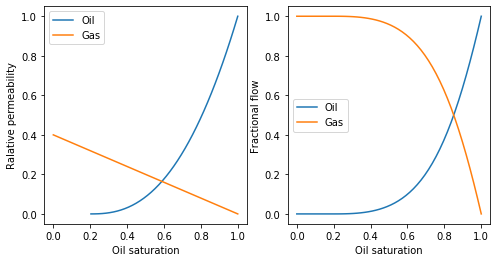

In [3]:
# Relative permeability function
def kro(So):
    return ((So-0.2) / (1-0.2))**2.5 

def krg(So):
    return 0.4*(1-So)

# Viscosity ratio (oil / gas)
M = 10

# Fractional flow function
def fo(So):
    with np.errstate(divide='ignore', invalid='ignore'):
        fo = np.where(So>0.2, 1/(1+M*krg(So)/kro(So)), 0)
    return fo

# Oil saturation array
So = np.linspace(0,1,50) 

# Plot for your reference
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(So, kro(So), label='Oil')
ax[0].plot(So, krg(So), label='Gas')
ax[0].legend()
ax[0].set_xlabel('Oil saturation')
ax[0].set_ylabel('Ralative permeability')
ax[1].plot(So, fo(So), label='Oil')
ax[1].plot(So, 1-fo(So), label='Gas')
ax[1].legend()
ax[1].set_xlabel('Oil saturation')
ax[1].set_ylabel('Fractional flow')
fig.show()

### マルチセルモデル（MCM）

各セルのクラスを作成する。このクラスの中で、下記操作を行なう

*   初期状態の設定
*   セルの更新
    *   流入成分を受け取る
    *   PTフラッシュ
    *   流出成分の計算






In [0]:
class Cells():
    def __init__(self, Vcell, feed, Zi, kik, verbose=False):
        self.m = Mixture(feed)      # Set initial mixture component
        self.Zi = Zi                # Set initial mixture mole fraction
        self.m.set_BIPs(kik)        # Set Binary interaction coefficients
        self.m.set_composition(Zi)  # Set initial mixture mole fraction
        
        # Initial PT flash
        self.m.PT_flash(P,T,verbose=verbose)
        
        # note: need to be 1 phase (liquid oil)
        self.VmOil = self.m.VmLact      # Molar volume of oil (liquid phase), m3/mol 
        self.MjOil = Vcell/self.VmOil   # Mole of Oil in each cell initially, mol*(PV/m3)
        self.Mcell = self.Zi*self.MjOil # Overall mole amount in this cell, mol*(PV/m3)


    def update(self, Molin, verbose=False):

        self.Molin = Molin      # Mole fraction injected

        # Mixing with injected components
        self.Mcell = self.Mcell + Molin             # Overall mole amount, mol*(PV/m3)
        self.Mcell_total = np.sum(self.Mcell)       # Total mole amount, mol*(PV/m3)
        self.Ccell = self.Mcell/self.Mcell_total    # Overall mole fraction

        if verbose: # for check
            print('Mole amount in the cell before mixing         ',self.Mcell)
            print('Mole amount of inflow                         ',Molin)
            print('Mole amount in the cell after mixing          ',self.Mcell)
            print('Overall mole amount in the cell after mixing   {0:.3f}'.format(self.Mcell_total))
            print('Mole fraction in the cell after mixing        ',self.Ccell) # fraction
            
        # PT Flash
        self.m.set_composition(self.Ccell)      # Set current overall mole fraction 
        self.m.PT_flash(P,T,verbose=verbose)    # PT Flash

        self.Mcell = self.m.Zi * self.Mcell_total

        # Calculate outflow mole amount

        # 1-1. Calculate volume of Luqiud phase
        # Volume = Total mole amount * relative mole amount * Molar volume 
        if self.m.phase =='two-phase' or self.m.phase =='liquid':
            VL = self.Mcell_total * self.m.Lact * self.m.VmLact     # Volume of liquid, PV
        else:
            VL = 0

        # 1-1. Calculate volume of Vapor phase
        if self.m.phase =='two-phase' or self.m.phase =='vapor':
            VV = self.Mcell_total * self.m.Vact * self.m.VmVact     # Volume of vapor, PV
        else:
            VV = 0

        # 2. Calculate excess volume of mixture
        Vm = VL + VV        # Volume of Mixture after PT Flash, PV
        exVm = Vm - Vcell   # Excess Volume of Mixture after PT Flash, PV

        # 3. Calculate outflow volume of each phase based on fractional flow
        self.So = VL / Vm       # Liquid phase saturation
        self.Sg = VV / Vm       # Vapor phase saturation
        ffo = fo(self.So)       # Fractional flow of liquid
        ffg = 1 - ffo           # Fractional flow of vapor
        qo = min(VL,exVm*ffo) + max(0,exVm*ffg-VV)  # Outflow volume of liquid, PV
        qg = min(VV,exVm*ffg) + max(0,exVm*ffo-VL)  # Outflow volume of vapor, PV

        # ----------
        self.So = (VL-qo)/Vcell  # Liquid phase saturation after outflow
        self.Sg = (VV-qg)/Vcell  # Vapor phase saturation after outflow
        # ----------

        # 4. Outflow mole amount of component in each phase
        if self.m.phase =='two-phase' or self.m.phase =='liquid':
            Molout_o = qo/self.m.VmLact * self.m.Xiact
        else:
            Molout_o = 0

        if self.m.phase =='two-phase' or self.m.phase =='vapor':
            Molout_g = qg/self.m.VmVact * self.m.Yiact
        else:
            Molout_g = 0

        # 5. Outflow mole amount of each component
        self.Molout = Molout_o + Molout_g

        self.Mcell = self.Mcell - self.Molout

        if verbose: # for check
            print()
            print('Excess Volume of Mixture after PT Flash        {0:.6f} PV'.format(exVm))
            print('Saturation                                     {0:.3f}, {1:.3f}'.format(self.So, self.Sg))
            print('Fractional flow                                {0:.3f}, {1:.3f}'.format(ffo,ffg))
            print('Outflow rate                                   {0:.6f}, {1:.6f} PV/step'.format(qo,qg))
            print('Outflow mole rate                              {0:.3f}, {1:.3f} mol(PV/m3)/step'.format(Molout_o,Molout_g))
            print('Outflow mole amount of each component         ',self.Molout,'mol(PV/m3)/step')
            print('Overall mole amount in cell after flow        ',self.Mcell,'mol(PV/m3)')

### メインループ

In [0]:
def main(feed, Zi, kik, MjCO2, ncell, Vcell, tstep):

    # Initialization
    Zi = np.array(Zi) # Initial oil mole fraction array
    clist = []
    for i in range(ncell):
        clist.append(Cells(Vcell, feed, Zi, kik))

    # Data stored
    Ki = np.zeros((tstep,ncell,4))*np.nan   # K values
    Zg = np.zeros((tstep,ncell,4))*np.nan   # Z factor of gas phase
    Zo = np.zeros((tstep,ncell,4))*np.nan   # Z factor of liquid phase
    So = np.zeros((tstep,ncell))*np.nan     # Oil saturation
    Sg = np.zeros((tstep,ncell))*np.nan     # Gas saturation
    out = np.zeros((tstep,4))*np.nan  # Z factor of gas phase

    for ts in range(tstep):
        print('\rTime step:', ts, end='') #, flush=True)
        Molin = [0, 0, 0, MjCO2] # mol*(PV/m3)
        
        for i, c in enumerate(clist):
            # print('Cell No.{0}'.format(i))
            c.update(Molin)
            Molin = c.Molout

            Ki[ts,i] = c.m.Ki
            Zg[ts,i] = c.m.Yiact
            Zo[ts,i] = c.m.Xiact
            So[ts,i] = c.So
            Sg[ts,i] = c.Sg

        out[ts] = Molin

    return Zo, Zg, So, Sg, Ki, out

### アニメーション用の関数

In [0]:
def plot_anim(Zo, Zg, So, Sg, Ki):

    # First set up the figure, the axes, and the plot element
    fig, ax = plt.subplots(4,1,sharex=True, figsize=(12,8))
    plt.close()
    ax[0].set_xlim(0,ncell)
    ax[0].set_ylim(0,1)
    ax[1].set_ylim(0,3)
    ax[2].set_ylim(0,1)
    ax[3].set_ylim(0,1)
    ax[3].set_xlabel("Cell No.")
    ax[0].set_ylabel("Saturation")
    ax[1].set_ylabel("K value")
    ax[2].set_ylabel("Mole fraction\n in gas phase")
    ax[3].set_ylabel("Mole fraction\n in oil phase")

    line_So, = ax[0].plot([], [], label='So')
    line_Sg, = ax[0].plot([], [], label='Sg')
    line_Ki, line_Zg, line_Zo = [0]*4, [0]*4, [0]*4
    for i in range(Ki.shape[2]):
        line_Ki[i], = ax[1].plot([], [])
        line_Zg[i], = ax[2].plot([], [])
        line_Zo[i], = ax[3].plot([], [])

    ax[0].legend(loc='upper right')
    ax[1].legend(iter(line_Ki), ("C1","C4","C10","CO2"), loc='upper right')
    ax[2].legend(iter(line_Zg), ("C1","C4","C10","CO2"), loc='upper right')
    ax[3].legend(iter(line_Zo), ("C1","C4","C10","CO2"), loc='upper right')
    ax[1].axhline(y=1.0, color='gray', linestyle=':')

    # animation function: this is called sequentially
    def animate(i):
        line_So.set_data(np.linspace(0,ncell-1,ncell),So[i])
        line_Sg.set_data(np.linspace(0,ncell-1,ncell),Sg[i])
        for j in range(Ki.shape[2]):
            line_Ki[j].set_data(np.linspace(0,ncell-1,ncell),Ki[i,:,j])
            line_Zg[j].set_data(np.linspace(0,ncell-1,ncell),Zg[i,:,j])
            line_Zo[j].set_data(np.linspace(0,ncell-1,ncell),Zo[i,:,j])
        ax[0].set_title("step "+str(i))
        return (line_So,line_Sg,*line_Ki,*line_Zg,*line_Zo,)

    anim = animation.FuncAnimation(fig, animate, frames=Ki.shape[0], interval=150, blit=True)
    # return HTML(anim.to_jshtml())
    return HTML(anim.to_html5_video())

## 設定




### 温度・圧力・セル数／容積

ここでの設定値は、**加藤 (1982)** にならった。**加藤 (1982)** では、12.4 MPaのとき、このプロセスはMulti Contact Miscibleとなるとされている。

In [0]:
# Temperature
T = 344.25 # K

# Pressure
# 13.8MPa (2000psi): FCM
# 12.4MPa (1800psi): MCM
# 10.3MPa (1500psi): Immiscible
P = 12.4e6/1e5 # BarA

# Number of cell
ncell = 100

# Pore volume of each cell
Vcell = 1/ncell # PV

### 成分系

C1-C4-C10-CO2の4成分系で計算することにする。必要なBIPは論文から探してきた。

In [0]:
# Set components which you need.
methane = Components(name='methane', Pc=46.00155, Tc=190.6, omega=0.008)
butane = Components(name='butane', Pc=37.996875, Tc=425.2, omega=0.193)
decane = Components(name='decane', Pc=21.0756, Tc=617.6, omega=0.49)
co2 = Components(name='co2', Pc=73.7646, Tc=304.2, omega=0.225)

feed = [methane, butane, decane, co2]

kik = np.array([[0     , 0.0133, 0.0422, 0.0919],
                [0.0133, 0     , 0     , 0.1300],
                [0.0422, 0     , 0     , 0.1020],
                [0.0919, 0.1300, 0.1020, 0     ]
                ])

### 初期油層流体の確認

初期の油層流体は、C1-C4-C10の3成分系とする。それぞれのモル分率は、[0.25, 0.30, 0.45]とした。 

In [9]:
# Initial oil composition
# methane, n-butane, n-decane, co2
Zi = np.array([0.25, 0.30, 0.45, 0.0]) # mole fraction

m = Mixture(feed)
m.set_composition(Zi)
m.set_BIPs(kik)
m.PT_flash(P,T,verbose=True)


                       Feed components : ['methane', 'butane', 'decane', 'co2']
                    Feed mole fraction : [0.25 0.3  0.45 0.  ]

PT Flash at 344.2 degK and 124.0 BarA.

                                 Phase : liquid
Relative mole fraction of liquid phase : 1.0000
 Relative mole fraction of vapor phase : 0.0000
              z factor of liquid phase : 0.6168
               z factor of vapor phase : nan
          Molar volume of liquid phase : 0.000142 m3/mol
           Molar volume of vapor phase : nan m3/mol
         Mole fraction in liquid phase : [0.25 0.3  0.45 0.  ]
          Mole fraction in vapor phase : nan
                              K values : [2.32308826 0.27823001 0.01163806        nan]


True

初期成分比でのPTフラッシュの結果、液相1相で存在することを確認できる。次に、この油のモル体積と、1つのセルに存在するモル量を確認しておく。

In [10]:
VmOil = m.VmLact # m3/mol
print('Molar volume of oil: {0:.6f} m3/mol'.format(VmOil))

MjOil = Vcell/VmOil # mol*(PV/m3)
print('Mole of Oil in each cell initially: {0:.2f} mol(PV/m3)'.format(MjOil))

Molar volume of oil: 0.000142 m3/mol
Mole of Oil in each cell initially: 70.24 mol(PV/m3)


### 圧入CO2

タイムステップ毎に、セルの容積の半分を圧入する。この温度圧力条件でのCO2のモル体積と、セル体積の半分に相当するモル量を計算しておく。


In [11]:
VmCO2 = co2.get_Vm(P, T)[0] # m3/mol
print('Molar volume of carbon dioxide: {0:.6f} m3/mol'.format(VmCO2))

MjCO2 = Vcell*0.5/VmCO2 # mol*(PV/m3)
print('Mole of carbon dioxide injected each time step: {0:.2f} mol(PV/m3)'.format(MjCO2))

Molar volume of carbon dioxide: 0.000124 m3/mol
Mole of carbon dioxide injected each time step: 40.21 mol(PV/m3)


## MCMでのCO2-EORの計算

最大計算ステップは、1.2PVのCO2を圧入した時点とする。

In [12]:
tmax = 1.2 # PV
tstepmax = int(tmax/(Vcell*0.5)) # t step max
print('Total time step:',tstepmax)

Total time step: 240


In [13]:
Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, tstepmax)
# Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, 10)
plot_anim(Zo, Zg, So, Sg, Ki)

Time step: 239

初期状態では、油のみ存在している（So=1）。時間を進めると、例えば、CO2を0.6PV圧入した時点（ステップ120）では、Cell No.41近辺で各成分のk値が1に近づいていることが分かる。こればガス相と油相が似た相を形成していることを示しており、Multi Contact Miscibility が達成されていると考えられる。

## Immiscible condition のとき

**加藤 (1982)** では、10.3 MPaのとき、プロセスは Immiscible displacement となるとされている。

In [15]:
# 10.3MPa (1500psi): Immiscible
P = 10.3e6/1e5 # BarA

Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, tstepmax)
# Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, 100)
plot_anim(Zo, Zg, So, Sg, Ki)

Time step: 239

圧力が低い場合、各成分のk値は離れており、ミシビリティは達成できていない。MCMと比べて中質～重質炭化水素成分の回収効率が低いことがわかる。また、流動の下流側の油相内のモル分率を見ると、大きなメタンバンクが形成されていること、早期のCO2ブレークスルーのが特徴的である。


## First Contact Miscible のとき

**加藤 (1982)** では、10.3 MPaのとき、プロセスは Immiscible condition displacement となるとされている。

In [16]:
# 13.8MPa (2000psi): FCM
P = 13.8e6/1e5 # BarA

Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, tstepmax)
# Zo, Zg, So, Sg, Ki, out = main(feed, Zi, kik, MjCO2, ncell, Vcell, 100)
plot_anim(Zo, Zg, So, Sg, Ki)

Time step: 239

一方、圧力が高い場合、２相となるセルはなく、常にどちらか１相となっている。この前後では、各成分のk値は１に収束しており、ガス相と油相は連続的に変化していると考えられる。また、各相内の各成分のモル分離はCO2との混合で同様に変化しており、First Contact Miscibilityが達成できていると考えられる。

*End of notebook...*